# 🎧 Emotion Detection from Voice using Machine Learning

**Objective:**  
Build a machine learning model that detects human emotion from speech using the RAVDESS dataset.

**Dataset Used:**  
[RAVDESS - Audio Only (Speech)](https://zenodo.org/record/1188976)  
Path: `data/Audio_Speech_Actors_01-24/`

**Steps Covered:**
1. Importing Required Libraries  
2. Audio Feature Extraction (MFCC, Chroma, Mel)  
3. Feature Scaling  
4. Train-Test Split  
5. Model Training with Hyperparameter Tuning (Random Forest + SVM)  
6. Model Evaluation (Accuracy, Confusion Matrix, Classification Report)  
7. Saving the Best Model and Scaler  
8. Live Emotion Detection using Microphone (with confidence & speech output)
9. Compare Accuracy of All Models
10. Visualize Most Important Features


## Step 1: Import Required Libraries

We begin by importing all necessary libraries for audio processing, feature extraction,
machine learning model building, evaluation, and real-time voice prediction.


In [24]:
import os, warnings, joblib, pyttsx3
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import librosa, sounddevice as sd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
warnings.filterwarnings("ignore")


## Step 2: Extract Audio Features (MFCC, Chroma, Mel)

In this step, we extract useful features from audio files that help distinguish emotions.
We use three common feature sets: MFCC (to capture tone), Chroma (pitch info), and Mel Spectrogram (frequency-based).
Each audio file is converted into a numerical feature vector for training.


In [25]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    return np.hstack((mfcc, chroma, mel))

X, y = [], []
base_path = "data/Audio_Speech_Actors_01-24/"

for actor in os.listdir(base_path):
    actor_folder = os.path.join(base_path, actor)
    if not os.path.isdir(actor_folder):
        continue
    for file in os.listdir(actor_folder):
        if file.endswith(".wav"):
            emotion_code = file.split("-")[2]
            label = emotion_map.get(emotion_code)
            if label:
                file_path = os.path.join(actor_folder, file)
                try:
                    features = extract_features(file_path)
                    X.append(features)
                    y.append(label)
                except:
                    print("❌ Error processing:", file_path)

X = np.array(X)
y = np.array(y)

print("✅ Feature extraction complete. Shape:", X.shape)


✅ Feature extraction complete. Shape: (1440, 180)


## Visualize Class Distribution

Before training, it's useful to visualize the number of samples per emotion label.
If the classes are imbalanced, it may affect model performance — especially accuracy and recall.


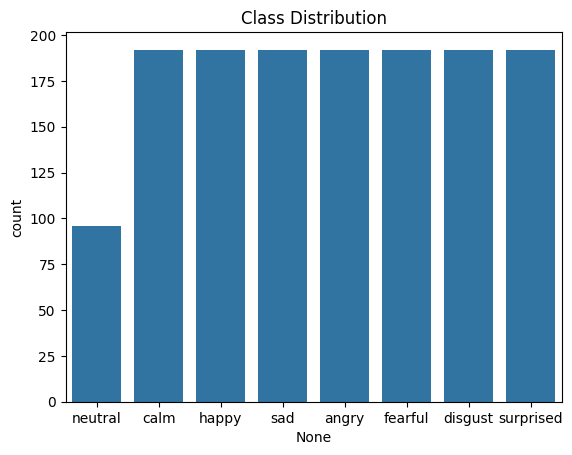

In [26]:
sns.countplot(x=pd.Series(y)); plt.title("Class Distribution"); plt.show()


## Step 3: Scale Features and Create Train/Test Sets

To ensure all features contribute equally to the model, we standardize the data using StandardScaler.
We also split the dataset into training and testing sets using a stratified 80-20 split to preserve class balance.


In [27]:
scaler   = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42)


## Step 4: Train a Random Forest Model with Hyperparameter Tuning

We use GridSearchCV to find the best hyperparameters for Random Forest.
This helps improve the accuracy and generalization of the model by trying different tree configurations and depths.


In [28]:
rf_grid = {
    "n_estimators":[100,200,300],
    "max_depth":[None,10,20,30],
    "min_samples_split":[2,4,6],
    "min_samples_leaf":[1,2,3]
}
rf_cv = GridSearchCV(RandomForestClassifier(), rf_grid, cv=3,
                     n_jobs=-1, verbose=1).fit(X_tr, y_tr)
rf_best = rf_cv.best_estimator_
print("Best RF params:", rf_cv.best_params_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


## Step 5: Train an SVM Model for Comparison

To compare model performance, we also train a Support Vector Machine (SVM).
SVMs are great for classification, especially when dealing with high-dimensional feature vectors like audio features.


In [29]:
svm_grid = {"C":[0.1,1,10], "kernel":["rbf","poly"], "gamma":["scale","auto"]}
svm_cv   = GridSearchCV(SVC(probability=True), svm_grid, cv=3,
                        n_jobs=-1, verbose=1).fit(X_tr, y_tr)
svm_best = svm_cv.best_estimator_
print("Best SVM params:", svm_cv.best_params_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best SVM params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


## Step 6: Evaluate and Compare Model Performance

We evaluate both models using accuracy score, classification report (precision, recall, F1-score),
and a confusion matrix to visualize how well each emotion is predicted.
This step helps us decide which model to keep.



Random Forest Accuracy: 0.5590
              precision    recall  f1-score   support

       angry       0.71      0.66      0.68        38
        calm       0.69      0.82      0.75        38
     disgust       0.37      0.61      0.46        38
     fearful       0.61      0.56      0.59        39
       happy       0.44      0.36      0.39        39
     neutral       0.50      0.32      0.39        19
         sad       0.62      0.53      0.57        38
   surprised       0.61      0.51      0.56        39

    accuracy                           0.56       288
   macro avg       0.57      0.54      0.55       288
weighted avg       0.57      0.56      0.56       288



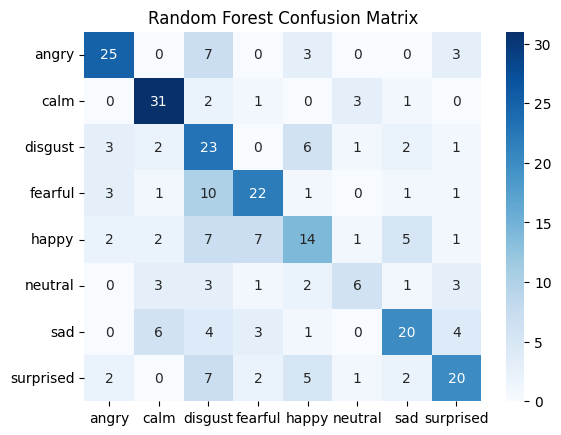


SVM Accuracy: 0.6146
              precision    recall  f1-score   support

       angry       0.70      0.74      0.72        38
        calm       0.67      0.79      0.72        38
     disgust       0.56      0.63      0.59        38
     fearful       0.57      0.59      0.58        39
       happy       0.58      0.46      0.51        39
     neutral       0.41      0.37      0.39        19
         sad       0.61      0.58      0.59        38
   surprised       0.69      0.64      0.67        39

    accuracy                           0.61       288
   macro avg       0.60      0.60      0.60       288
weighted avg       0.61      0.61      0.61       288



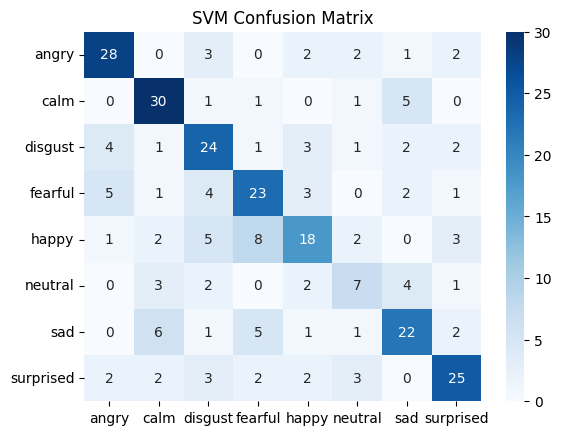

In [30]:
def evaluate(model, name):
    pred = model.predict(X_te)
    print(f"\n{name} Accuracy: {accuracy_score(y_te, pred):.4f}")
    print(classification_report(y_te, pred))
    cm = confusion_matrix(y_te, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"{name} Confusion Matrix"); plt.show()

evaluate(rf_best,  "Random Forest")
evaluate(svm_best, "SVM")


## Step 7: Save the Best Performing Model and Scaler

We save the best-performing model (either Random Forest or SVM) using joblib for future use.
We also save the feature scaler so that real-time inputs can be scaled in the same way.


In [31]:
best = rf_best if accuracy_score(y_te, rf_best.predict(X_te)) >= \
                accuracy_score(y_te, svm_best.predict(X_te)) else svm_best
joblib.dump(best,   "emotion_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Saved: emotion_model.pkl & scaler.pkl")


✅ Saved: emotion_model.pkl & scaler.pkl


## Step 8: Real-Time Emotion Detection from Microphone

Now we allow the user to speak for a few seconds, record the audio,
extract the same MFCC, Chroma, and Mel features, and predict the emotion on the fly.
We also provide the confidence level and speak the result using a text-to-speech engine.


In [32]:
import numpy as np
import sounddevice as sd
import librosa
import pyttsx3

# ----------- Function to Record Audio -----------
def record_audio(duration=3, sr=22050):
    print("🎙️  Recording...")
    audio = sd.rec(int(duration * sr), samplerate=sr, channels=1)
    sd.wait()
    return audio.flatten(), sr

# ----------- Function to Extract Features from Audio Array -----------
def features_from_array(y, sr):
    mfccs   = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    chromas = librosa.feature.chroma_stft(y=y, sr=sr)
    mels    = librosa.feature.melspectrogram(y=y, sr=sr)

    mfccs   = np.mean(mfccs.T, axis=0)
    chromas = np.mean(chromas.T, axis=0)
    mels    = np.mean(mels.T, axis=0)

    return np.hstack((mfccs, chromas, mels))

# ----------- Real-Time Prediction Demo -----------
audio, sr = record_audio()
features = features_from_array(audio, sr).reshape(1, -1)
features = scaler.transform(features)  # scaler must be loaded/trained

probs = best.predict_proba(features)[0]  # best = your trained model
idx = np.argmax(probs)
emotion = best.classes_[idx]
confidence = probs[idx] * 100

# ----------- Speak the Result -----------
msg = f"Detected emotion: {emotion} ({confidence:.1f}% confidence)"
print(msg)

engine = pyttsx3.init()
engine.say(msg)
engine.runAndWait()


🎙️  Recording...
Detected emotion: angry (63.1% confidence)


## Step 9: Compare Accuracy of All Models

We compare the accuracy of both models (Random Forest and SVM) on the test data.
This helps us justify why we choose the final model for real-time prediction.


In [33]:
from sklearn.metrics import accuracy_score

model_scores = {}
models = {
    "Random Forest": rf_best,
    "SVM": svm_best
}

for name, model in models.items():
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    model_scores[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Random Forest Accuracy: 0.5590
SVM Accuracy: 0.6146


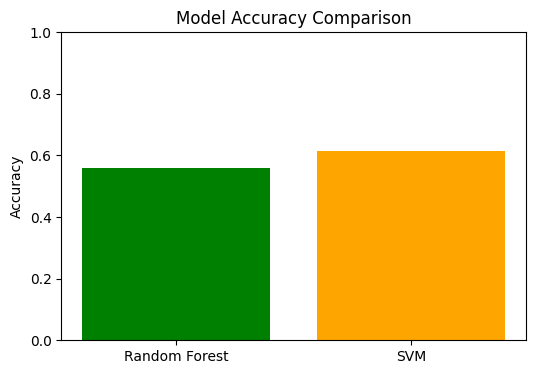

In [34]:
plt.figure(figsize=(6,4))
plt.bar(model_scores.keys(), model_scores.values(), color=['green', 'orange'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


## Step 10: Visualize Most Important Features

To understand what the model is learning, we plot the top 20 features that the Random Forest model finds most useful.
This gives transparency to the decision-making process.


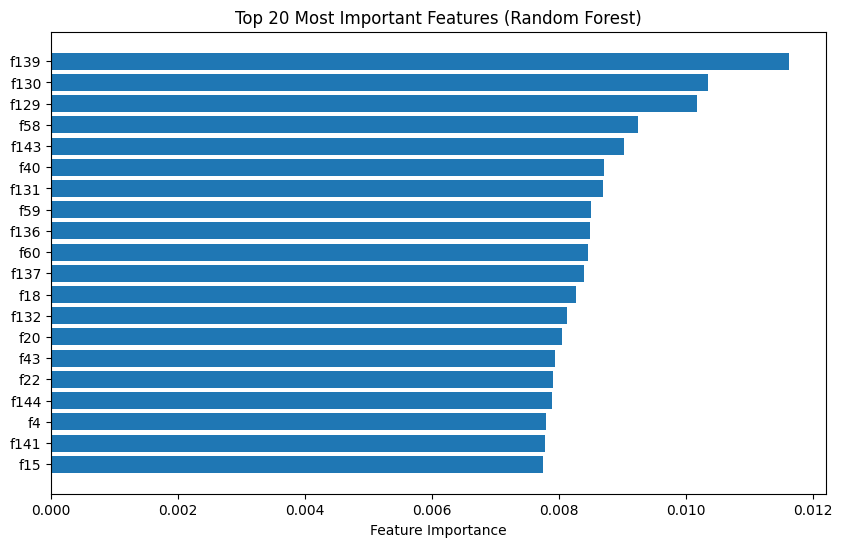

In [35]:
importances = rf_best.feature_importances_
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [f"f{i}" for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 20 Most Important Features (Random Forest)")
plt.show()
